Import Statements

In [1]:
import numpy as np  
import pandas as pd  
from pandas_datareader import data as wb  
import matplotlib.pyplot as plt  
from scipy.stats import norm
%matplotlib inline

Get the past 10 years of stock price close data for Proctor & Gamble

In [2]:
ticker = 'PG' 
data = pd.DataFrame()
data[ticker] = wb.DataReader(ticker, data_source='yahoo', start='2010-1-1')['Adj Close']

Estimate historical log returns

In [3]:
log_returns = np.log(1 + data.pct_change())
log_returns.tail()

,PG
Date,
2020-07-22,0.008519
2020-07-23,0.006449
2020-07-24,-0.001587
2020-07-27,0.002854
2020-07-28,0.012274


Plot PG's price

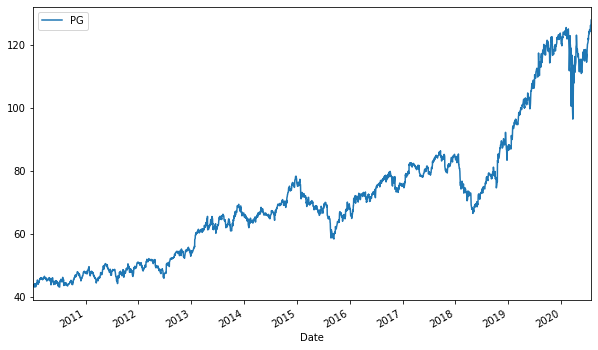

In [4]:
data.plot(figsize=(10, 6));

Plot log returns

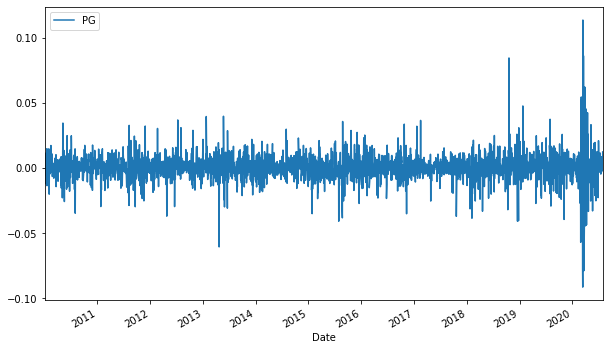

In [5]:
log_returns.plot(figsize = (10, 6))

find the mean

In [6]:
u = log_returns.mean()
u

PG    0.000403
dtype: float64

find the variance

In [7]:
var = log_returns.var()
var

PG    0.000118
dtype: float64